In [1]:
import numpy as np
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
import sys
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm as svm_sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Preprocessing Training data
fruit_images_t = []
labels_t = []
imagesize = 45
for fruit_dir_path in glob.glob("fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (imagesize, imagesize))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_t.append(image)
        labels_t.append(fruit_label)
fruit_images_t = np.array(fruit_images_t)
labels_t = np.array(labels_t)

# Preprocessing Validation data
fruit_images_v = []
labels_v = []
for fruit_dir_path in glob.glob("fruits-360/Validation/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (imagesize, imagesize))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_v.append(image)
        labels_v.append(fruit_label)
fruit_images_v = np.array(fruit_images_v)
labels_v = np.array(labels_v)

# Create dicts/arrays for Training Data
# What here do we need??
names = np.unique(labels_t)
n_classes = len(names)
n_instances_t = [np.count_nonzero(labels_t == names[i]) for i in range(n_classes)]
n_instances_v = [np.count_nonzero(labels_v == names[i]) for i in range(n_classes)]
ids = [k for k in range(0, n_classes)]
name_id = list(zip(names, ids))
id_to_name = {id: name for (name, id) in name_id}
name_to_id = {name: id for (name, id) in name_id}
label_ids_t = np.array([name_to_id[x] for x in labels_t])

label_ids_v = np.array([name_to_id[x] for x in labels_v])
#End of preprocessing stage

In [2]:
#Run PCA
ncomp = 24
scaler = StandardScaler()
#PCA on training set
scaled_images = scaler.fit_transform([im.flatten() for im in fruit_images_t])
pca = PCA(n_components=ncomp)
pca_result_t = pca.fit_transform(scaled_images)
#PCA on validation set
images_scaled = scaler.transform([im.flatten() for im in fruit_images_v])
pca_result_v = pca.transform(images_scaled)
#Split training set
##DO WE NEED THIS??##
X_train, X_test, y_train, y_test = train_test_split(pca_result_t, label_ids_t, test_size=0)

The sum of the top 24 principal components is 0.7444960918939706


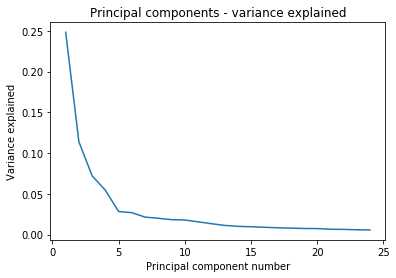

In [3]:
plt.plot([i+1 for i in range(ncomp)], pca.explained_variance_ratio_)
plt.xlabel('Principal component number')
plt.ylabel('Variance explained')
plt.title('Principal components - variance explained')
print('The sum of the top', ncomp, 'principal components is', np.sum(pca.explained_variance_ratio_))

In [4]:
# Train and test PCA - SVM with the best parameters found
svm = svm_sk.SVC(C=1.0, kernel='poly', degree=1)
svm = svm.fit(X_train, y_train)
#Predict training set and compute and print accuracy
svm_prediction_t = svm.predict(pca_result_t)
svm_precision_t = accuracy_score(svm_prediction_t, label_ids_t)
print('Accuracy of SVM on test set: ', svm_precision_t)
# Predict validation set and compute and print accuracy
svm_prediction_v = svm.predict(pca_result_v)
svm_precision_v = accuracy_score(svm_prediction_v, label_ids_v)
print('Accuracy of SVM on validation set: ', svm_precision_v)

Accuracy of SVM on test set:  1.0
Accuracy of SVM on validation set:  0.9673317481649953


Confusion matrix for SVM on validation set


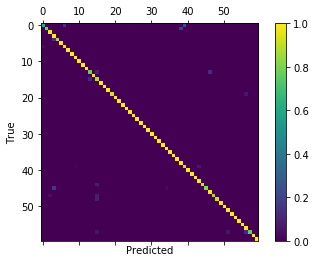

In [5]:
# Plot confusion matrix representing the SVM
print('Confusion matrix for SVM on validation set')
cm_svm_v = confusion_matrix(label_ids_v, svm_prediction_v)
cm_svm_v = normalize(cm_svm_v, axis=1, norm='l1')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [6]:
# Train and test PCA - RF with the best parameters found
rf = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=None)
rf = rf.fit(X_train, y_train)
#Predict training set and compute and print accuracy
rf_prediction_t = rf.predict(pca_result_t)
rf_precision_t = accuracy_score(rf_prediction_t, label_ids_t)
print('Accuracy of RF on test set: ', rf_precision_t)
#Predict test set and compute and print accuracy
rf_prediction_v = rf.predict(pca_result_v)
rf_precision_v = accuracy_score(rf_prediction_v, label_ids_v)
print('Accuracy of RF on test set: ', rf_precision_v)

Accuracy of RF on test set:  1.0
Accuracy of RF on test set:  0.9172955649746718


Confusion matrix for RF on validation set


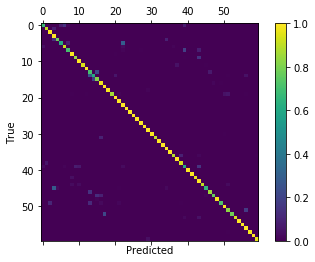

In [7]:
# Plot confusion matrix representing the PCA - RF
print('Confusion matrix for RF on validation set')
cm_rf_v = confusion_matrix(label_ids_v, rf_prediction_v)
cm_rf_v = normalize(cm_rf_v, axis=1, norm='l1')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_rf_v)
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

C:\Users\Eskil\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


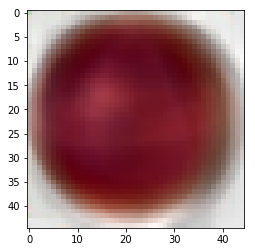

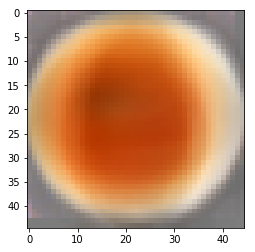

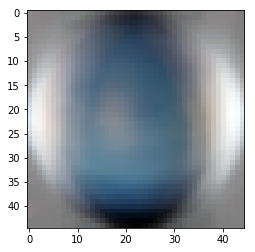

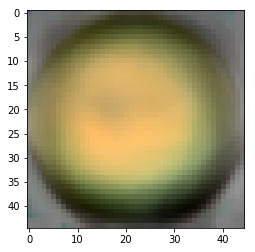

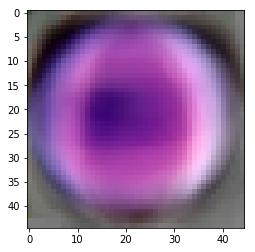

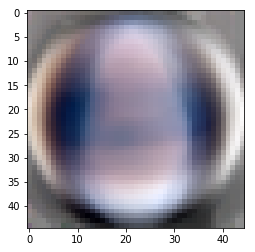

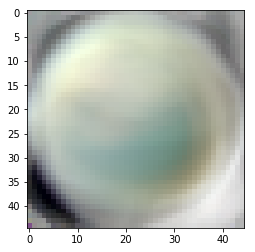

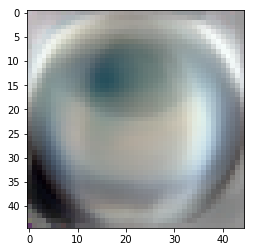

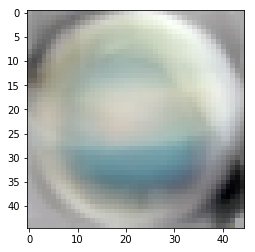

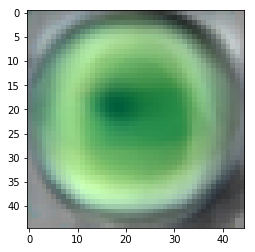

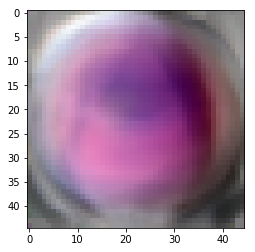

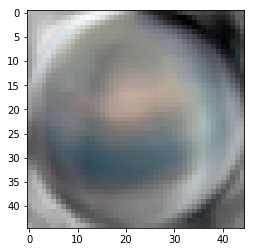

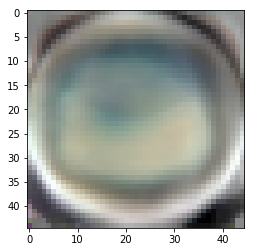

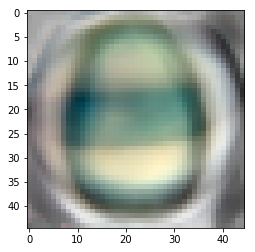

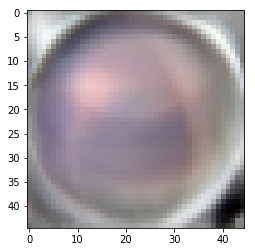

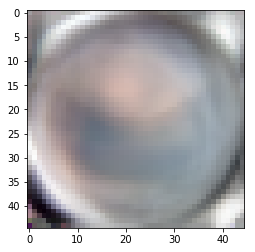

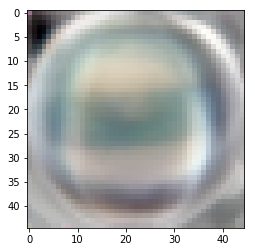

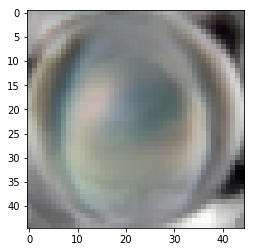

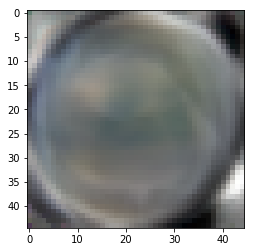

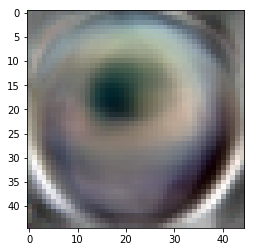

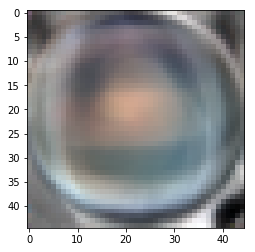

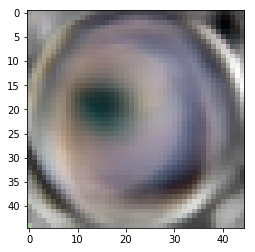

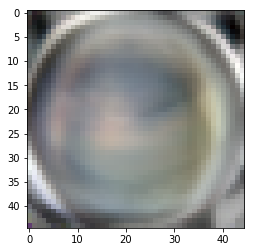

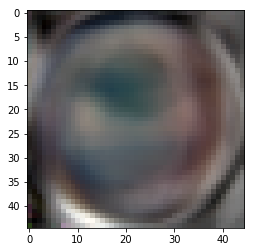

In [8]:
#Code for printing and saving the PCA components
for i in range(ncomp):
    #Map components to range [0,1] in order to print
    maxx = np.max(pca.components_[i])
    minn = np.min(pca.components_[i])
    diver = maxx - minn 
    im = (pca.components_[i].reshape((imagesize,imagesize,3)) -minn)/diver
    image = np.zeros((imagesize, imagesize, 3))
    #Change components from BGR to RGB 
    image[:,:,0] = im[:,:,2]
    image[:,:,1] = im[:,:,1]
    image[:,:,2] = im[:,:,0]
    plt.figure()
    plt.imshow(image)
    #Uncomment the following two lines to save files
    #filename = 'component%i.jpg' %(i+1)
    #plt.imsave(filename, image)

In [9]:
# Manual extraction of features from images

def color_features(img):
    gray_img_f = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() # make grayscale and invert b/w
    img_f = img.reshape((img.shape[0]*img.shape[1],3))
    mean_rgb = np.zeros(3)
    counts=0
    for k in range(img_f.shape[0]):
        if gray_img_f[k] <= 240: # somewhat arbitrary
            mean_rgb += img_f[k]
            counts += 1
            
    mean_rgb = mean_rgb / counts
    
    # Now let's find color variance, it's gonna be fun
    variance = np.sum(np.square(img_f-mean_rgb),axis=0)
    return list(mean_rgb) + list(variance)
    
def shape_features(img):
    gray_img = 255 - cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # make grayscale and invert b/w
    thresh = cv2.adaptiveThreshold(gray_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,11,2) # make image binary
    im2, cnt, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # Find connected components
    max_cnt = cnt[np.argmax([len(x) for x in cnt])] # Use the biggest component
    
    # Compute key features
    M = cv2.moments(max_cnt)
    ellipse = cv2.fitEllipse(max_cnt)
    min_max_ratio = min(ellipse[1][0] / ellipse[1][1],
                      ellipse[1][1] / ellipse[1][0])
    area_covered = M['m00'] / (ellipse[1][0] * ellipse[1][1])
    perimeter_to_area = M['m00'] / cv2.arcLength(max_cnt,False)
    
    return [min_max_ratio, area_covered, perimeter_to_area]
    
def get_features_from_img(img):
    return color_features(img) + shape_features(img)

def imgs_to_features(imgs):
    N = imgs.shape[0]
    features = np.zeros((N,9))
    for i in range(N):
        features[i,:] = get_features_from_img(imgs[i])
    return features

custom_features_t = imgs_to_features(fruit_images_t)
custom_features_v = imgs_to_features(fruit_images_v)
#custom_features_ov = imgs_to_features(fruit_images_ov)
# Scaled custom features
custom_scaler = StandardScaler()
cft = custom_scaler.fit_transform(custom_features_t)
cfv = custom_scaler.transform(custom_features_v)
#cftov = custom_scaler.transform(custom_features_ov)

# Split custom training set
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(cft, label_ids_t, test_size=0)

In [10]:
# Train the SVM classifier using the custom features
svm_c = svm_sk.SVC(kernel='poly',degree=1)
svm_c = svm_c.fit(X_train_c, y_train_c)
svm_train_predictions_c = svm_c.predict(X_train_c)

# Compute accuracy on training set
svm_precision_c = accuracy_score(svm_train_predictions_c, y_train_c) * 100
print("Accuracy with SVM (custom features) on training set: {0:.6f}".format(svm_precision_c))
# Predict with SVM on (custom features) Validation data
svm_prediction_v_c = svm_c.predict(cfv)

# Compute accuracy on validation set
svm_precision_v_c = accuracy_score(svm_prediction_v_c, label_ids_v) * 100
print("Accuracy with SVM on (custom features) Validation data: {0:.6f}".format(svm_precision_v_c))

Accuracy with SVM (custom features) on training set: 94.191954
Accuracy with SVM on (custom features) Validation data: 91.388401


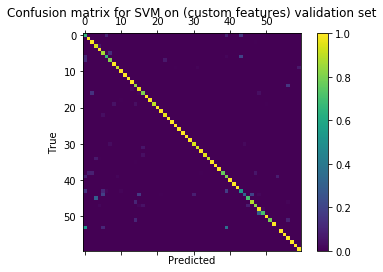

In [11]:
# Compute confusion matrix for SVM
cm_svm_v_c = confusion_matrix(label_ids_v, svm_prediction_v_c)
cm_svm_v_c = normalize(cm_svm_v_c, axis=1, norm='l1')

# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v_c)
plt.title('Confusion matrix for SVM on (custom features) validation set')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
# Train Random Forest (on custom features)
forest_c = RandomForestClassifier(n_estimators=100)
forest_c = forest_c.fit(X_train_c, y_train_c)

# Make predictions w/ both classifiers
forest_train_predictions_c = forest_c.predict(X_train_c)

# Compute accuracy scores
forest_precision_t_c = accuracy_score(forest_train_predictions_c, y_train_c) * 100 
print("Accuracy with RF (custom features) on training set: {0:.6f}".format(forest_precision_t_c))

# Predict with SVM on (custom features) Validation data# Predic 
forest_prediction_v_c = forest_c.predict(cfv)

# Compute accuracy scores for all classifiers
forest_precision_v_c = accuracy_score(forest_prediction_v_c, label_ids_v) * 100

print("Accuracy with RF on (custom features) Validation data: {0:.6f}".format(forest_precision_v_c))

Accuracy with RF (custom features) on training set: 100.000000
Accuracy with RF on (custom features) Validation data: 93.456012


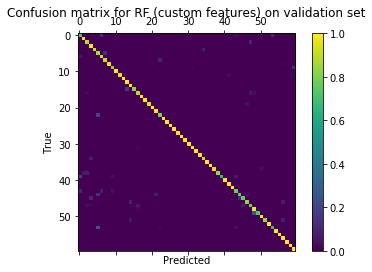

In [13]:
# Compute confusion matrix for RF classifier
cm_rf_v_c = confusion_matrix(label_ids_v, forest_prediction_v_c)
cm_rf_v_c = normalize(cm_rf_v_c, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_rf_v_c)
plt.title('Confusion matrix for RF (custom features) on validation set')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
def get_img_fft(img):
    r_img = np.zeros(img.shape)
    f = np.fft.fft2(img[:,:,0])
    f = np.fft.fftshift(f)
    f = np.absolute(f)
    r_img[:,:,0] = f
    f = np.fft.fft2(img[:,:,1])
    f = np.fft.fftshift(f)
    f = np.absolute(f)
    r_img[:,:,1] = f
    f = np.fft.fft2(img[:,:,2])
    f = np.fft.fftshift(f)
    r_img[:,:,2] = f
    f = np.absolute(f)
    
    return r_img.astype(int)

fft_imgs_t = [get_img_fft(img) for img in fruit_images_t]
fft_imgs_v = [get_img_fft(img) for img in fruit_images_v]
#fft_imgs_ov = [get_img_fft(img) for img in fruit_images_ov]

C:\Users\Eskil\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


In [15]:
# PCA Cell for FFT 
# Scale Training data and then run PCA on it
fft_scaler = StandardScaler()

scaled_images = fft_scaler.fit_transform([im.flatten() for im in fft_imgs_t])
fft_pca = PCA(n_components=50)
pca_result_fft_t = fft_pca.fit_transform(scaled_images)

# Split training set
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(pca_result_fft_t, label_ids_t, test_size=1)

# Scale Validation Data and run PCA on it
images_scaled = fft_scaler.transform([im.flatten() for im in fft_imgs_v])
pca_result_fft_v = fft_pca.transform(images_scaled)

# Scale our own Validation set and run PCA on it
#images_scaled = fft_scaler.transform([im.flatten() for im in fft_imgs_ov])
#pca_result_ov = fft_pca.transform(images_scaled)

In [16]:
cft_fft = pca_result_fft_t
cfv_fft = pca_result_fft_v

# Split custom training set
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(cft_fft, label_ids_t, test_size=0)

In [17]:
# Train the SVM classifier on the FFT-processed components
svm_fft = svm_sk.SVC(kernel='poly',degree=1)
svm_fft = svm_fft.fit(X_train_fft, y_train_fft)
svm_train_predictions_fft = svm_fft.predict(X_train_fft)

# Compute accuracy on training set
svm_precision_fft = accuracy_score(svm_train_predictions_fft, y_train_fft) * 100
print("Accuracy with SVM (FFT) on training set: {0:.6f}".format(svm_precision_fft))
# Predict with SVM on (custom features) Validation data
svm_prediction_v_fft = svm_fft.predict(cfv_fft)

# Compute accuracy on validation set
svm_precision_v_fft = accuracy_score(svm_prediction_v_fft, label_ids_v) * 100
print("Accuracy with SVM on (FFT) Validation data: {0:.6f}".format(svm_precision_v_fft))

Accuracy with SVM (FFT) on training set: 99.592845
Accuracy with SVM on (FFT) Validation data: 81.970433


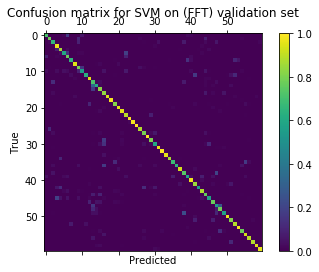

In [18]:
# Compute confusion matrix for SVM
cm_svm_v_fft = confusion_matrix(label_ids_v, svm_prediction_v_fft)
cm_svm_v_fft = normalize(cm_svm_v_fft, axis=1, norm='l1')

# Plot confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v_fft)
plt.title('Confusion matrix for SVM on (FFT) validation set')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
# Train Random Forest (on FFT)
forest_fft = RandomForestClassifier(n_estimators=100)
forest_fft = forest_fft.fit(X_train_fft, y_train_fft)

# Make predictions w/ both classifiers
forest_train_predictions_fft = forest_fft.predict(X_train_fft)

# Compute accuracy scores
forest_precision_t_fft = accuracy_score(forest_train_predictions_fft, y_train_fft) * 100 
print("Accuracy with RF (FFT) on training set: {0:.6f}".format(forest_precision_t_fft))

# Predict with SVM on (custom features) Validation data# Predic 
forest_prediction_v_fft = forest_fft.predict(cfv_fft)

# Compute accuracy scores for all classifiers
forest_precision_v_fft = accuracy_score(forest_prediction_v_fft, label_ids_v) * 100

print("Accuracy with RF on (FFT) Validation data: {0:.6f}".format(forest_precision_v_fft))

Accuracy with RF (FFT) on training set: 100.000000
Accuracy with RF on (FFT) Validation data: 80.130259


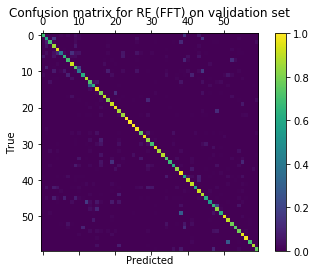

In [20]:
# Compute confusion matrix for RF classifier
cm_rf_v_fft = confusion_matrix(label_ids_v, forest_prediction_v_fft)
cm_rf_v_fft = normalize(cm_rf_v_fft, axis=1, norm='l1')

# Plot both confusion matrices (separate windows)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_rf_v_fft)
plt.title('Confusion matrix for RF (FFT) on validation set')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
# Finding the worst preforming classes of each method
# Find worst preforming classes in SVM classifier
n_show = 8 #0 < n_show < 60 = n_classes
svm_errors = [(1-cm_svm_v[i][i], 1-cm_svm_v_c[i][i], 1-cm_svm_v_fft[i][i], id_to_name[i]) for i in range(n_classes)]
svm_errors.sort(key=lambda tup: -(tup[0]+tup[1]+tup[2]))
print('\nWorst perfroming classes for SVM')
for i in range(n_show):
    print(svm_errors[i])

rf_errors = [(1-cm_rf_v[i][i], 1-cm_rf_v_c[i][i], 1-cm_rf_v_fft[i][i], id_to_name[i]) for i in range(n_classes)]
rf_errors.sort(key=lambda tup: -(tup[0]+tup[1]+tup[2]))
print('\nWorst perfroming classes for RF (FFT)')
print(rf_errors[:n_show])
"""
svm_errors_pca = [(1-cm_svm_v[i][i], id_to_name[i]) for i in range(n_classes)]
svm_errors_pca.sort(key=lambda tup: -tup[0])
print('Worst perfroming classes for SVM (PCA)')
print(svm_errors_pca[:n_show])
rf_errors_pca = [(1-cm_rf_v[i][i], id_to_name[i]) for i in range(n_classes)]
rf_errors_pca.sort(key=lambda tup: -tup[0])
print('\nWorst perfroming classes for RF (PCA)')
print(rf_errors_pca[:n_show])
svm_errors_c = [(1-cm_svm_v_c[i][i], id_to_name[i]) for i in range(n_classes)]
svm_errors_c.sort(key=lambda tup: -tup[0])
print('\nWorst perfroming classes for SVM (custom features)')
print(svm_errors_c[:n_show])
rf_errors_c = [(1-cm_rf_v_c[i][i], id_to_name[i]) for i in range(n_classes)]
rf_errors_c.sort(key=lambda tup: -tup[0])
print('\nWorst perfroming classes for RF (custom features)')
print(rf_errors_c[:n_show])
svm_errors_fft = [(1-cm_svm_v_fft[i][i], id_to_name[i]) for i in range(n_classes)]
svm_errors_fft.sort(key=lambda tup: -tup[0])
print('\nWorst perfroming classes for SVM (FFT)')
print(svm_errors_fft[:n_show])
rf_errors_fft = [(1-cm_rf_v_fft[i][i], id_to_name[i]) for i in range(n_classes)]
rf_errors_fft.sort(key=lambda tup: -tup[0])
print('\nWorst perfroming classes for RF (FFT)')
print(rf_errors_fft[:n_show])
"""


Worst perfroming classes for SVM
(0.3780487804878049, 0.3475609756097561, 0.28658536585365857, 'Apple Braeburn')
(0.0, 1.0, 0.012195121951219523, 'Pomegranate')
(0.08536585365853655, 0.6646341463414633, 0.23780487804878048, 'Peach Flat')
(0.18292682926829273, 0.2987804878048781, 0.41463414634146345, 'Pear')
(0.12650602409638556, 0.1686746987951807, 0.43975903614457834, 'Pear Monster')
(0.0, 0.28915662650602414, 0.42771084337349397, 'Pepino')
(0.06707317073170727, 0.19512195121951215, 0.4085365853658537, 'Nectarine')
(0.0, 0.4695121951219512, 0.12195121951219512, 'Peach')

Worst perfroming classes for RF (FFT)
[(0.38414634146341464, 0.12804878048780488, 0.5975609756097561, 'Apple Red 1'), (0.3719512195121951, 0.3292682926829268, 0.39634146341463417, 'Nectarine'), (0.3414634146341463, 0.23170731707317072, 0.3780487804878049, 'Pear'), (0.27710843373493976, 0.27108433734939763, 0.3674698795180723, 'Pepino'), (0.31707317073170727, 0.2621951219512195, 0.3109756097560976, 'Apple Braeburn'), 

"\nsvm_errors_pca = [(1-cm_svm_v[i][i], id_to_name[i]) for i in range(n_classes)]\nsvm_errors_pca.sort(key=lambda tup: -tup[0])\nprint('Worst perfroming classes for SVM (PCA)')\nprint(svm_errors_pca[:n_show])\nrf_errors_pca = [(1-cm_rf_v[i][i], id_to_name[i]) for i in range(n_classes)]\nrf_errors_pca.sort(key=lambda tup: -tup[0])\nprint('\nWorst perfroming classes for RF (PCA)')\nprint(rf_errors_pca[:n_show])\nsvm_errors_c = [(1-cm_svm_v_c[i][i], id_to_name[i]) for i in range(n_classes)]\nsvm_errors_c.sort(key=lambda tup: -tup[0])\nprint('\nWorst perfroming classes for SVM (custom features)')\nprint(svm_errors_c[:n_show])\nrf_errors_c = [(1-cm_rf_v_c[i][i], id_to_name[i]) for i in range(n_classes)]\nrf_errors_c.sort(key=lambda tup: -tup[0])\nprint('\nWorst perfroming classes for RF (custom features)')\nprint(rf_errors_c[:n_show])\nsvm_errors_fft = [(1-cm_svm_v_fft[i][i], id_to_name[i]) for i in range(n_classes)]\nsvm_errors_fft.sort(key=lambda tup: -tup[0])\nprint('\nWorst perfroming c

In [27]:
#Create latex code for creating tables
for i in range(n_show):
    print(svm_errors[i][3], '&', round(100*svm_errors[i][0],1), '&', round(100*svm_errors[i][1],1), '&', round(100*svm_errors[i][2],1), '&', round(100*(svm_errors[i][0]+svm_errors[i][1]+svm_errors[i][2])/3,1), '\\\\')
print('---------')
for i in range(n_show):
    print(rf_errors[i][3], '&', round(100*rf_errors[i][0],1), '&', round(100*rf_errors[i][1],1), '&', round(100*rf_errors[i][2],1), '&', round(100*(rf_errors[i][0]+rf_errors[i][1]+rf_errors[i][2])/3,1), '\\\\')

Apple Braeburn & 37.8 & 34.8 & 28.7 & 33.7 \\
Pomegranate & 0.0 & 100.0 & 1.2 & 33.7 \\
Peach Flat & 8.5 & 66.5 & 23.8 & 32.9 \\
Pear & 18.3 & 29.9 & 41.5 & 29.9 \\
Pear Monster & 12.7 & 16.9 & 44.0 & 24.5 \\
Pepino & 0.0 & 28.9 & 42.8 & 23.9 \\
Nectarine & 6.7 & 19.5 & 40.9 & 22.4 \\
Peach & 0.0 & 47.0 & 12.2 & 19.7 \\
---------
Apple Red 1 & 38.4 & 12.8 & 59.8 & 37.0 \\
Nectarine & 37.2 & 32.9 & 39.6 & 36.6 \\
Pear & 34.1 & 23.2 & 37.8 & 31.7 \\
Pepino & 27.7 & 27.1 & 36.7 & 30.5 \\
Apple Braeburn & 31.7 & 26.2 & 31.1 & 29.7 \\
Pear Monster & 23.5 & 21.7 & 33.7 & 26.3 \\
Pear Abate & 14.5 & 16.3 & 45.2 & 25.3 \\
Banana Red & 38.0 & 0.6 & 36.1 & 24.9 \\
